In [1]:
%load_ext Cython

In [2]:
%%cython --annotate

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

cdef inline float float_max(float a, float b): return a if a >= b else b
cdef inline float float_min(float a, float b): return a if a <= b else b

ctypedef np.float_t DTYPE_t

@cython.cdivision(True)
cpdef float cython_get_antropogenic_release(float xt, float c1, float c2, float r1, 
                             float r2, float w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    cdef float rule, at, var1, var2, test
    
    var1 = (xt-c1)/r1
    var1 = abs(var1)
    var2 = (xt-c2)/r2
    var2 = abs(var2)
    
    rule = w1*(var1**3)+(1-w1)*(var2**3)
    at = float_min(float_max(rule, 0.01), 0.1)
    return at
    
@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, float stdev=0.001, 
               float alpha=0.4, float delta=0.98, float c1=0.25,
               float c2=0.25, float r1=0.5, float r2=0.5, float w1=0.5, 
               int nsamples=100, int steps=100):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
#     np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        decisions[t-1] = cython_get_antropogenic_release(X[t-1], c1, c2, r1, r2, 
                                                  w1)
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.abs(np.diff(decisions)) > 0.01)/(steps-1)
    return X, utility, inertia, reliability

In [3]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench.em_framework.model import Replicator, BaseModel

#instantiate the model
class ReplicatorModel(Replicator, BaseModel):
    pass
lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2), 
                     RealParameter("w1", 0, 1)
                     ]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [4]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, perform_experiments
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(policies=500)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 500 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


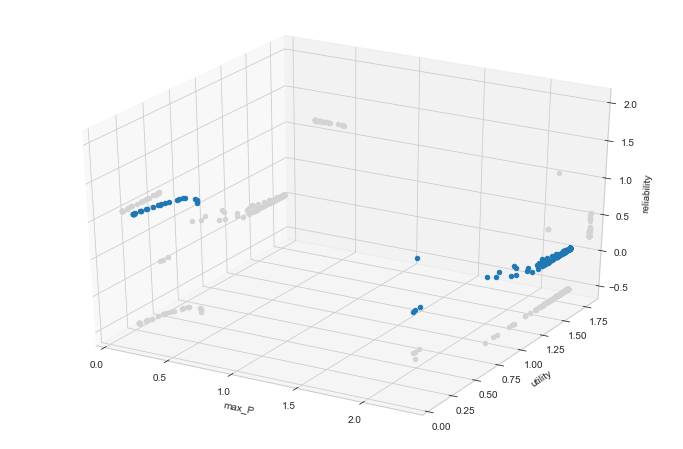

In [5]:
from mpl_toolkits.mplot3d import Axes3D

experiments, outcomes = results

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x = outcomes['max_P']
y = outcomes['utility']
z = outcomes['reliability']

ax.scatter(x, y, z, depthshade=False)

ax.scatter(x, z, c='lightgrey', zdir='y', zs=2, depthshade=False)
ax.scatter(y, z, c='lightgrey', zdir='x', zs=-0, depthshade=False)
ax.scatter(x, y, c='lightgrey', zdir='z', zs=-0.5, depthshade=False)

ax.set_xlabel("max_P")
ax.set_ylabel("utility")
ax.set_zlabel("reliability")
plt.show()

# reference scenario optimization

In [6]:
from ema_workbench.em_framework.optimization import to_dataframe

class Callback(object):
    '''Callable object for tracking progress of optimization over generations
    '''

    def __init__(self):
        self.progress = []
        self.archive_history = []

    def __call__(self, optimizer):
        self.progress.append(optimizer.algorithm.archive.improvements)
        
        dvnames = optimizer.problem.parameter_names
        outcome_names = optimizer.problem.outcome_names
        
        self.archive_history.append(to_dataframe(optimizer, dvnames,
                                                 outcome_names))
callback = Callback()

with MultiprocessingEvaluator(lake_model) as evaluator:
    optimization_results = evaluator.optimize(searchover='levers', 
                      nfe=100000, epsilons=[0.05,]*len(lake_model.outcomes),
                      callback=callback)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO

[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[Main

[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/INFO] 76 cases completed
[MainProce

[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/INFO] 76 cases completed
[MainProcess/INFO] 95 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 38 cases completed
[MainProcess/INFO] 57 cases completed
[MainProcess/

[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 164 policies * 1 model(s) = 164 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 163 policies * 1 model(s) = 163 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 128 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 161 policies * 1 model(s) = 161 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 163 policies * 1 model(s) = 163 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 166 policies * 1 model(s) = 166 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[

[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 167 policies * 1 model(s) = 167 experiments
[MainProcess/INFO] 33 cases completed
[M

[MainProcess/INFO] performing 1 scenarios * 165 policies * 1 model(s) = 165 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 163 policies * 1 model(s) = 163 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenario

[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[MainProcess/INFO] 165 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 1 scenarios * 168 policies * 1 model(s) = 168 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 132 cases completed
[

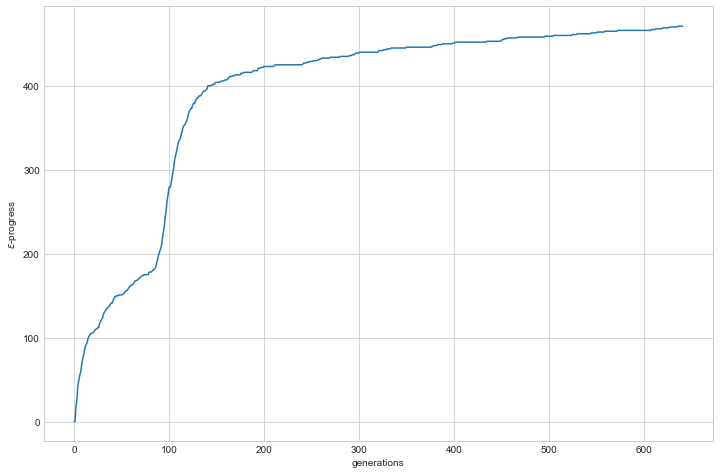

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(callback.progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('generations')
plt.show()

In [8]:
x_opt = optimization_results['max_P']
y_opt = optimization_results['utility']
z_opt = optimization_results['reliability']

In [9]:
complete_x = np.concatenate((x, x_opt))
complete_y = np.concatenate((y, y_opt))
complete_z = np.concatenate((z, z_opt))
complete_inertia = np.concatenate((outcomes['inertia'], optimization_results['inertia']))
labeling = np.asarray(['random guess',]*500+['optimization',]*z_opt.shape[0])
data = {'max p':complete_x, 'utility':complete_y, 'reliability':complete_z, 
        'inertia':complete_inertia, 'type':labeling}

combined = pd.DataFrame(data)


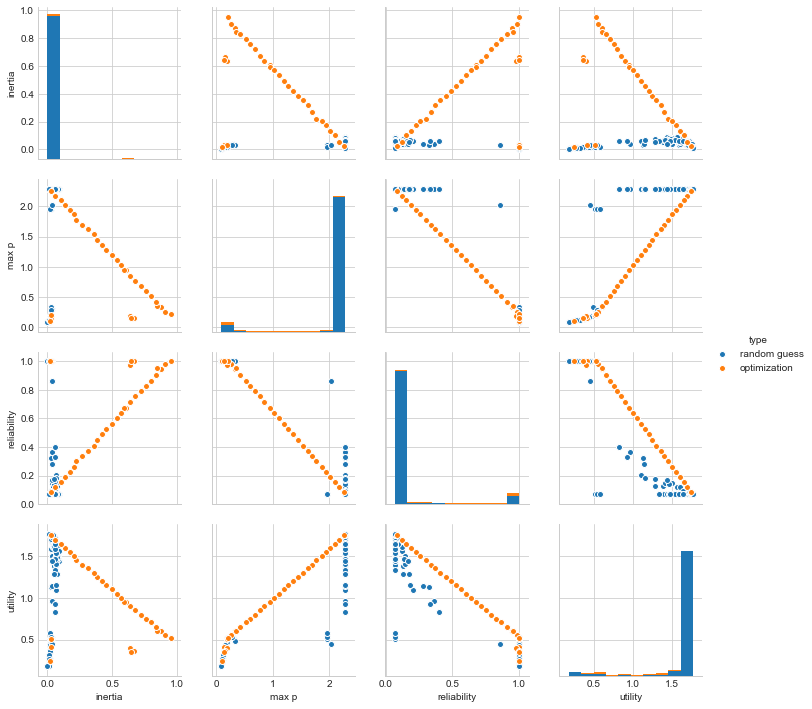

In [10]:
sns.pairplot(combined, hue='type')
plt.show()

# animation

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

sns.set_style('white')

x = outcomes['max_P']
y = outcomes['utility']
z = outcomes['reliability']

x_opt = optimization_results['max_P']
y_opt = optimization_results['utility']
z_opt = optimization_results['reliability']

# Axes limits
pholims = (0, 2.6)
utilims = (-0.5, 2.6)
rellims = (0, 1.1)

experiments, outcomes = results

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# setup plot
ax.view_init(elev=20, azim=120)
ax.set_xlim(pholims)
ax.set_ylim(utilims)
ax.set_zlim(rellims)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

x_arrow = Arrow3D(pholims, [utilims[1], utilims[1]], [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="<|-", color="k")
y_arrow = Arrow3D([pholims[0],pholims[0]], utilims, [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
z_arrow = Arrow3D([0,0], [utilims[1], utilims[1]], rellims,
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
ax.add_artist(x_arrow)
ax.add_artist(y_arrow)
ax.add_artist(z_arrow)

# initial guesses
x = outcomes['max_P']
y = outcomes['utility']
z = outcomes['reliability']

ax.scatter(x, y, z, c='#3182bd', depthshade=False)

c = '#deebf7' # '#9ecae1'
# c = 'lightgrey'
ax.scatter(x, z, c=c, zdir='y', zs=utilims[1], depthshade=False)
ax.scatter(y, z, c=c, zdir='x', zs=pholims[0], depthshade=False)
ax.scatter(x, y, c=c, zdir='z', zs=-0.1, depthshade=False)

# optimization
archive = callback.archive_history
x_opt = archive[0]['max_P']
y_opt = archive[0]['utility']
z_opt = archive[0]['reliability']

d3_scatter = ax.scatter(x_opt, y_opt, z_opt, c='#e6550d', depthshade=False)

c = '#fee6ce' #'#fdae6b'
xz_shadow = ax.scatter(x_opt, z_opt, c=c, zdir='y', zs=utilims[1], depthshade=False)
yz_shadow = ax.scatter(y_opt, z_opt, c=c, zdir='x', zs=pholims[0], depthshade=False)
xy_shadow = ax.scatter(x_opt, y_opt, c=c, zdir='z', zs=-0.1, depthshade=False)

ax.set_xlabel("max_P", fontsize=20)
ax.set_ylabel("utility", fontsize=20)
ax.set_zlabel("reliability", fontsize=20)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

def update(front):
    x_opt = front['max_P'].values
    y_opt = front['utility'].values
    z_opt = front['reliability'].values
    
    d3_scatter._offsets3d = (x_opt, y_opt, z_opt)

    x_offset = np.ones(x_opt.shape)*pholims[0]
    y_offset = np.ones(x_opt.shape)*utilims[1]
    z_offset = np.ones(x_opt.shape)*-0.1

    xz_shadow._offsets3d = (x_opt, y_offset, z_opt)
    yz_shadow._offsets3d = (x_offset, y_opt, z_opt)
    xy_shadow._offsets3d = (x_opt, y_opt, z_offset)
    return d3_scatter

animated = animation.FuncAnimation(fig, update, 
                                   frames=callback.archive_history,
                                   blit=False)
plt.close(animated._fig)
HTML(animated.to_html5_video())
# see also http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/ 

In [12]:
from ema_workbench import save_results
from io import BytesIO, StringIO
import tarfile

base = 'learning'
animated.save('./data/{}.mp4'.format(base))
optimization_results.to_csv('./data/{}.cvs'.format(base))
save_results(results, './data/{}_guess.tar.gz'.format(base))
pd.Series(callback.progress).to_csv('./data/{}_progress.csv'.format(base))

file_name = './data/{}_archives.tar.gz'.format(base)
with tarfile.open(file_name, 'w:gz') as z:
    for i, entry in enumerate(callback.archive_history):
        file_buffer = StringIO()
        entry.to_csv(file_buffer)
        
        csv_as_string = file_buffer.getvalue()
        fh = BytesIO(csv_as_string.encode('UTF-8'))
        tarinfo = tarfile.TarInfo(str(i)+'.csv')
        tarinfo.size = len(csv_as_string)
        
        z.addfile(tarinfo, fh)
        

[MainProcess/INFO] results saved successfully to /Users/jhkwakkel/Documents/workspace/resilience17/data/learning_guess.tar.gz
